In [ ]:
#get paired pic of light turned on and off
#take difference of pics
#blur
#threshold the blobs
#centroid of blobs

In [47]:
import os, sys, inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from models.models import create_model

from importlib import reload
from pbw_utils import zdataset, show, labwidget, paintwidget, renormalize, nethook, imgviz, pbar
from pbw_utils.stylegan2 import load_seq_stylegan

from PIL import Image
import numpy as np
import torch 
import torch.nn.functional as F
import torchvision.transforms as T

In [69]:
model = load_seq_stylegan('bedroom', mconv='seq', truncation=0.90)
nethook.set_requires_grad(False, model)
light_layer = ['layer8']
light_unit = [265]
frac = [((float(150) * 2 - 100) / 100.0)]

In [70]:
def get_lit_scene(z, fracs, layers, units):
    #TODO: modify for multiple layers
    layername = layers[0]
    def change_light(output):
        for frac, unit in zip(fracs, units): 
            output.style[:, int(unit)] = 10 * frac
        return output
    with nethook.Trace(model, f'{layername}.sconv.mconv.modulation', edit_output=change_light):
        return model(z)


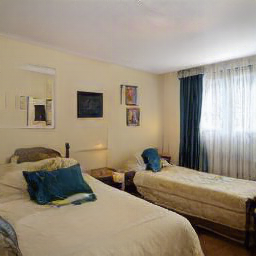


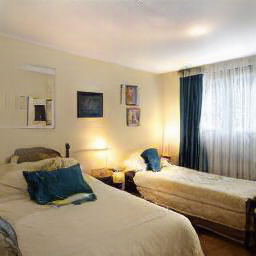


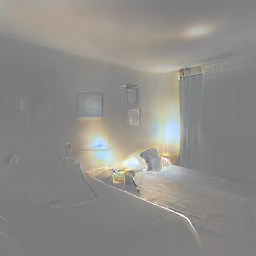

In [89]:
#z = torch.load('fixed_z.pt')
z = torch.randn(1, 512, device='cuda')
original = model(z)[0]
show(renormalize.as_image(original))

lit = get_lit_scene(z, frac, light_layer, light_unit)[0]
show(renormalize.as_image(lit))

diff = lit - original
show(renormalize.as_image(diff))

In [84]:
print(torch.max(lit))
print(torch.max(original))
print(torch.max(diff))

tensor(1.1797, device='cuda:0')
tensor(1.1493, device='cuda:0')
tensor(1.9350, device='cuda:0')



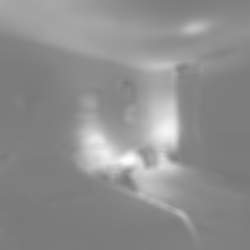


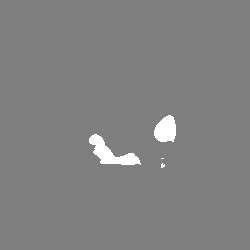

In [90]:
dim = 7
blur_kernel = (1/2**(dim))*torch.ones(dim, dim)
blur_kernel = blur_kernel.repeat(1, 3, 1, 1).cuda()
blur_conv = F.conv2d(diff.unsqueeze(0), blur_kernel)

# blur_kernel = T.GaussianBlur(dim)
# gray = torch.mean(diff, dim=0)
# blur_conv = blur_kernel(gray.unsqueeze(0).unsqueeze(0))
show(renormalize.as_image(blur_conv[0]))
thresholded = (blur_conv > 0.7).float() * 1
show(renormalize.as_image(thresholded[0]))

In [46]:
print(torch.max(diff))
print(torch.max(blur_conv))

tensor(1.9359, device='cuda:0')
tensor(1.6306, device='cuda:0')
